<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/main/note/03_LinearRegression_appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from mlxtend.regressor import LinearRegression
from statsmodels.formula.api import ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 最小二乗推定に関する補足

最小二乗推定量 $\hat{\beta}$ は正規方程式を利用して次のように求めていた。

$$\hat{\beta} = (X^\top X)X^\top y$$

しかし、この方法ではいくつかの問題点が存在する。
* $X$ が正則でない場合に $\hat{\beta}$ を求めることができない
* パラメーターが増えると計算が遅くなる。

これらの問題に対処するためのいくつかの手法を示す。

In [2]:
ad = pd.read_csv("https://www.statlearning.com/s/Advertising.csv", index_col=0)

In [3]:
ad["TV2"] = ad["TV"] * 2
ad.head()

,TV,radio,newspaper,sales,TV2
1,230.1,37.8,69.2,22.1,460.2
2,44.5,39.3,45.1,10.4,89.0
3,17.2,45.9,69.3,9.3,34.4
4,151.5,41.3,58.5,18.5,303.0
5,180.8,10.8,58.4,12.9,361.6


## 多重共線性への対処
### 0. Xが正則の場合：QR分解

$A$ が行、または列でフルランクの場合 $A=QR$ と分解できる。ここで、 $Q$ は直交行列であり、 $R$ は上三角行列である。よって、最小二乗推定量は

$$\hat{\beta} = R^{-1}Q^\top y$$

で求められる。

In [55]:
try:
  model_qr = ols(formula='sales ~ newspaper + radio + TV + TV2', data=ad).fit(method="qr")
  print(model_qr.summary2())
except np.linalg.LinAlgError as e:
  print(e)

Singular matrix


### 1. $X$ が正則でない場合：特異値分解(SVD)

$X$ の**Moore-Penrose一般逆行列**（擬似逆行列）$X^+$ を以下の条件を満たす行列と定義する。
1. $XX^+X = X$
1. $X^+XX^+=X$
1. $(X^+X)^\top = X^+X$
1. $(XX^+)^\top = XX^+$

任意の行列 $A$ は $A = U\Sigma V^\top$ と分解できる、ただし、 $U,V$ は
直交行列、 $\Sigma$ は $A$ の特異値からなる対角行列である。

また、 $A^+$ は $A^+ = U\Sigma^+V$ と分解でき、 $\Sigma^+$ は特異値の逆数からなる対角行列になる。

この行列による最小二乗推定量は

$$\hat\beta = X^+y$$

となり、(L2)ノルムを最小化する(->Ridge回帰と同じ?)。この方法はQR分解より非効率的である。

In [29]:
model_svd = ols(formula='sales ~ newspaper + radio + TV + TV2', data=ad).fit(method="pinv")
print(model_svd.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.896   
Dependent Variable: sales            AIC:                780.3622
Date:               2021-12-26 05:45 BIC:                793.5555
No. Observations:   200              Log-Likelihood:     -386.18 
Df Model:           3                F-statistic:        570.3   
Df Residuals:       196              Prob (F-statistic): 1.58e-96
R-squared:          0.897            Scale:              2.8409  
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       2.9389    0.3119   9.4223  0.0000   2.3238  3.5540
newspaper      -0.0010    0.0059  -0.1767  0.8599  -0.0126  0.0105
radio           0.1885    0.0086  21.8935  0.0000   0.1715  0.2055
TV              0.0092    0.0003  32.8086  0.0000   0.0086  0.0097
TV2             0.01

## 各ライブラリで利用可能な手法

|言語|ライブラリ|||
|:-:|:-:|:--|:--|
|R     |stats::lm|QR分解|[リンク](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/lm.html)|
|Python|statsmodels.regression.linear_model.OLS|擬似逆行列/qr分解|[リンク](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit)|
|Python|mlxtend.regressor.LinearRegression|閉形式/QR分解/特異値分解/勾配降下法/確率的勾配降下法|[リンク](http://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/)|
|Python|sklearn.linear_model.LinearRegression|不明(xGELSD?)|[リンク](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)|

## 計算量の問題

勾配降下法

解析的に解くことを諦めて、**勾配降下法**を使う。




In [38]:
X = ad[["TV"]].to_numpy()
y = ad["sales"].to_numpy()

# 標準化
X = scipy.stats.zscore(X)
y = scipy.stats.zscore(y)

In [51]:
sgd_lr = LinearRegression(method='sgd',
                          eta=0.01, 
                          epochs=100, 
                          random_seed=0, 
                          minibatches=len(y))
sgd_lr.fit(X, y)

In [47]:
qr_lr = LinearRegression(method='qr')
qr_lr.fit(X, y)

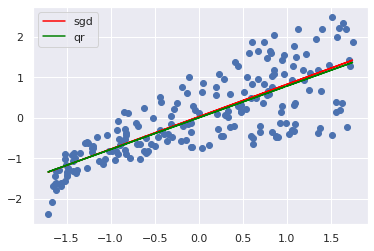

In [54]:
reg_X = np.linspace(-2, 2, 100)

plt.scatter(X.T, y)
plt.plot(X, sgd_lr.predict(X), color="red", label="sgd")
plt.plot(X, qr_lr.predict(X), color="green", label="qr")
plt.legend()
plt.show()

### 参考
* ［第3版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践
ISBN: 978-4295010074
* データ分析基礎線形代数の基礎知識 (増強版)
[リンク](http://ds.k.kyoto-u.ac.jp/e-learning_files/data_analysis_basic/slide-03a.pdf)
* mlxtend User Guide LinearRegression
[リンク](https://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/)
* 【解説】 一般逆行列
[リンク](https://www.slideshare.net/wosugi/ss-79624897)